<a href="https://colab.research.google.com/github/cthmayo/match-predictor/blob/main/Predicting-Wrestle-Kingdom-15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the Wrestle Kingdom 15 card using machine learning

In this project, I will attempt to use machine learning to predict the results of the New Japan Pro Wrestling Wrestle Kingdom 15 card.

Broadly speaking, there are three stages to achieving this:
1. Extract NJPW match data from www.profightdb.com.
2. Data preparation.
3. Machine learning and predictions.

# Imports

BeautifulSoup is the Python library I will use 

In [ ]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import datetime
from dateutil.parser import parse
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
import matplotlib.pyplot as plt

# Webscraping

Webscraping the cards list of cards from profightdb.

In [ ]:
def get_cards_from_page(url):
  page = urlopen(url)
  html = page.read().decode('utf-8')
  soup = BeautifulSoup(html, "html.parser")
  links = soup.find_all('a')
  cards = [link['href'] for link in links if 'cards/njpw/' in link['href']]
  return cards

Need to interpret star ratings.

In [ ]:
def star_rating(raw_rating):
  if raw_rating == '':
    return None
  if 'DUD' in raw_rating:
    return 0
  rating = 0
  for char in raw_rating:
    star_dict = {'*':1, '¼':0.25, '½':0.5, '¾':0.75, '-':0}
    rating += star_dict[char]
  if '-' in raw_rating:
    rating = -rating
  return rating

Code to extract all the singles matches from a particular card, and output in a pandas dataframe.

In [ ]:
def get_matches(url_ending):
  # load the page
  url = 'http://www.profightdb.com' + url_ending
  page = urlopen(url)
  html = page.read().decode('utf-8')
  soup = BeautifulSoup(html, "html.parser")

  # define basic data about the event
  event = soup.find_all('h1')[-1].text.strip()
  date = None
  venue = None
  attendance = None

  # get all the table rows
  rows = [row for row in soup.find_all('tr')]
  matches = []

  for row in soup.find_all('tr'):
    cells = row.find_all('td')
    # get date
    if len(cells) > 0 and cells[0].text[:5] == 'Date:':
      date = parse(cells[0].text[6:])
    # get venue
    if len(cells) > 0 and cells[0].text[:6] == 'Venue:':
      venue = cells[0].text[8:]
    # get attendance
    if len(cells) > 0 and cells[0].text[:11] == 'Attendance:':
      attendance = cells[0].text[12:].replace(',','')
    if len(cells) > 3:
      matches.append(cells)
  
  df_matches = pd.DataFrame()
  ranking = len(matches)
  for match in matches: # go through every match
    anomaly_flag = False
    d = {}
    if not ('&' in match[1].text) and not (',' in match[1].text): # only looking at singles matches
      d['Card Ranking'] = ranking
      d['Result Descriptor'] = match[2].text
      d['Match Time'] = match[4].text
      d['Stipulation'] = match[5].text
      if 'title change' in match[6].text:
        d['Title'] = match[6].text[:-14].strip()
      else:
        d['Title'] = match[6].text.strip()
      if len(match) > 7:
        d['WON Rating'] = star_rating(match[7].text)
      else:
        d['WON Rating'] = None

      links = match[1].find_all('a')
      if len(links) == 0:
        anomaly_flag = True
        d['Person 1 ID'] = 'unknown'
      else:
        d['Person 1 ID'] = links[0]['href']
      if match[1].text[-3:].lower() == '(c)':
        d['Person 1 Champion'] = True
        d['Person 1 Name'] = match[1].text[:-4]
      else:
        d['Person 1 Champion'] = False
        d['Person 1 Name'] = match[1].text

      links = match[3].find_all('a')
      if len(links) == 0:
        anomaly_flag = True
        d['Person 2 ID'] = 'unknown'
      else:
        d['Person 2 ID'] = links[0]['href']
      if match[3].text[-3:].lower() == '(c)':
        d['Person 2 Champion'] = True
        d['Person 2 Name'] = match[3].text[:-4]
      else:
        d['Person 2 Champion'] = False
        d['Person 2 Name'] = match[3].text
      
      df_matches = df_matches.append(d, ignore_index = True)

      if anomaly_flag == True:
        print('Issue with',d['Person 1 Name'],'vs',d['Person 2 Name'],'from',event)
    ranking -= 1
    df_matches['Date'] = date
    df_matches['Event'] = event
    df_matches['Venue'] = venue
    df_matches['Attendance'] = attendance

  return df_matches

In [ ]:
get_matches('/cards/njpw/g1-climax-2020---day-19-34899.html')

,Date,Event,Venue,Attendance,Card Ranking,Match Time,Person 1 Champion,Person 1 ID,Person 1 Name,Person 2 Champion,Person 2 ID,Person 2 Name,Result Descriptor,Stipulation,Title,WON Rating
0,2020-10-18,NJPW G1 Climax 2020 - Day 19,"Ryogoku Kokugikan, Tokyo, Tokyo",2928,1.0,35:12,0.0,/wrestlers/kota-ibushi-3893.html,Kota Ibushi,0.0,/wrestlers/seiya-sanada-5261.html,SANADA,def. (pin),,,4.25


In [ ]:
def get_all_matches_from_page(url):
  cards = get_cards_from_page(url)
  df_matches = pd.DataFrame()
  for card in cards:
    card_matches = get_matches(card)
    df_matches = df_matches.append(card_matches)
  return df_matches

Code to extract all matches on profightdb under 'njpw-cards'

In [ ]:
def get_all_matches_ever():
  df_matches = pd.DataFrame()
  for i in range(1,350):
    url = 'http://www.profightdb.com/cards/njpw-cards-pg'+str(i)+'-no-27.html'
    print('Getting matches from',url)
    page_matches = get_all_matches_from_page(url)
    df_matches = df_matches.append(page_matches)
  return df_matches

In [ ]:
all_matches = get_all_matches_ever()

Getting matches from http://www.profightdb.com/cards/njpw-cards-pg1-no-27.html
Getting matches from http://www.profightdb.com/cards/njpw-cards-pg2-no-27.html
Getting matches from http://www.profightdb.com/cards/njpw-cards-pg3-no-27.html
Getting matches from http://www.profightdb.com/cards/njpw-cards-pg4-no-27.html
Getting matches from http://www.profightdb.com/cards/njpw-cards-pg5-no-27.html
Getting matches from http://www.profightdb.com/cards/njpw-cards-pg6-no-27.html
Getting matches from http://www.profightdb.com/cards/njpw-cards-pg7-no-27.html
Getting matches from http://www.profightdb.com/cards/njpw-cards-pg8-no-27.html
Getting matches from http://www.profightdb.com/cards/njpw-cards-pg9-no-27.html
Getting matches from http://www.profightdb.com/cards/njpw-cards-pg10-no-27.html
Getting matches from http://www.profightdb.com/cards/njpw-cards-pg11-no-27.html
Getting matches from http://www.profightdb.com/cards/njpw-cards-pg12-no-27.html
Getting matches from http://www.profightdb.com/ca

In [ ]:
all_matches.head()

,Date,Event,Venue,Attendance,Card Ranking,Match Time,Person 1 Champion,Person 1 ID,Person 1 Name,Person 2 Champion,Person 2 ID,Person 2 Name,Result Descriptor,Stipulation,Title,WON Rating
0,2020-12-23,NJPW Road to Tokyo Dome 2021 - Day 7,"Korakuen Hall, Tokyo, Tokyo",696,4.0,06:11,1.0,/wrestlers/toru-yano-2888.html,Toru Yano,0.0,/wrestlers/bad-luck-fale-6169.html,Bad Luck Fale,def.,Bodyslam Or Last Cornerpad Match,NJPW King Of Pro-Wrestling Title,None
0,2020-12-18,NJPW STRONG #20 - Detonation (airdate),"Oceanview Pavilion, Port Hueneme, California",unknown,4.0,,0.0,/wrestlers/rocky-romero-924.html,Rocky Romero,0.0,/wrestlers/danny-limelight-13988.html,Danny Limelight,def.,,,None
1,2020-12-18,NJPW STRONG #20 - Detonation (airdate),"Oceanview Pavilion, Port Hueneme, California",unknown,3.0,08:07,0.0,/wrestlers/jeff-cobb-9665.html,Jeff Cobb,0.0,/wrestlers/ryan-taylor-3883.html,Rust Taylor,def. (pin),,,None
2,2020-12-18,NJPW STRONG #20 - Detonation (airdate),"Oceanview Pavilion, Port Hueneme, California",unknown,1.0,14:16,0.0,/wrestlers/kenta-1895.html,KENTA,0.0,/wrestlers/brody-king-13562.html,Brody King,def. (pin),,,None
0,2020-12-12,NJPW Super J-Cup 2020 (airdate),"Oceanview Pavilion, Port Hueneme, California",unknown,9.0,09:36,0.0,/wrestlers/chris-bey-13995.html,Chris Bey,0.0,/wrestlers/clark-connors-14531.html,Clark Connors,def.,,,None


# Exploratory Data Analysis and Data Cleaning

Card Rankings

In [ ]:
all_matches['Card Ranking'].value_counts()

6.0     1406
7.0     1406
5.0     1150
4.0     1078
3.0     1059
2.0     1041
1.0     1037
8.0     1001
9.0      435
10.0     127
11.0      38
13.0      11
12.0      10
14.0       8
15.0       2
16.0       1
Name: Card Ranking, dtype: int64

Match times

In [ ]:
all_matches['Match Time'].value_counts()

         1277
10:00      97
15:00      45
20:00      29
30:00      29
         ... 
23:02       1
20:49       1
21:15       1
00:50       1
19:06       1
Name: Match Time, Length: 1479, dtype: int64

Check match times in seconds and generate histogram...

In [ ]:
def calculate_seconds(raw_time):
  a = raw_time.split(':')
  if len(a) == 2:
    return int(a[0])*60 + int(a[1])
  if len(a) == 3:
    return int(a[0])*3600 + int(a[1])*60 + int(a[2])

In [ ]:
times = [calculate_seconds(time) for time in all_matches['Match Time'] if ':' in time]

(array([1.270e+02, 3.980e+02, 1.585e+03, 2.406e+03, 1.631e+03, 9.080e+02,
        5.400e+02, 3.600e+02, 1.940e+02, 1.260e+02, 8.900e+01, 7.600e+01,
        4.000e+01, 2.700e+01, 8.000e+00, 6.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 8.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.00000e+00, 1.51820e+02, 3.02640e+02, 4.53460e+02, 6.04280e+02,
        7.55100e+02, 9.05920e+02, 1.05674e+03, 1.20756e+03, 1.35838e+03,
        1.50920e+03, 1.66002e+03, 1.81084e+03, 1.96166e+03, 2.11248e+03,
        2.26330e+03, 2.41412e+03, 2.56494e+03, 2.71576e+03, 2.86658e+03,
        3.01740e+03, 3.16822e+03, 3.31904e+03, 3.46986e+03, 3.62068e+03,
        3.7

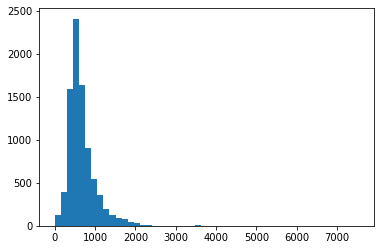

In [ ]:
plt.hist(times,bins=50)

Championship: who has a championship in each match?

In [ ]:
all_matches['Person 1 Champion'].value_counts()

0.0    9273
1.0     537
Name: Person 1 Champion, dtype: int64

In [ ]:
all_matches['Person 2 Champion'].value_counts()

0.0    9592
1.0     218
Name: Person 2 Champion, dtype: int64

Person 1

In [ ]:
all_matches['Person 1 Name'].value_counts()

Hiroshi Tanahashi      300
Yuji Nagata            254
Hirooki Goto           215
Ryusuke Taguchi        203
Manabu Nakanishi       175
                      ... 
Shota Chochyashvili      1
Roberto Soto             1
Hajime Ohara             1
Sterling Riegel          1
Mark Coleman             1
Name: Person 1 Name, Length: 597, dtype: int64

Person 2

In [ ]:
all_matches['Person 2 Name'].value_counts()

Toru Yano                                                                                                                                   247
Yutaka Yoshie                                                                                                                               214
Wataru Inoue                                                                                                                                185
Hirooki Goto                                                                                                                                175
Naofumi Yamamoto                                                                                                                            174
                                                                                                                                           ... 
Don Arakawa                                                                                                                             

Person 1 ID

In [ ]:
all_matches['Person 1 ID'].value_counts()

/wrestlers/hiroshi-tanahashi-920.html    301
/wrestlers/yuji-nagata-676.html          256
/wrestlers/togi-makabe-3235.html         218
/wrestlers/hirooki-goto-926.html         215
/wrestlers/ryusuke-taguchi-3252.html     203
                                        ... 
/wrestlers/ricky-fuji-4849.html            1
/wrestlers/marco-corleone-388.html         1
/wrestlers/dick-togo-265.html              1
/wrestlers/mohammed-yone-2997.html         1
/wrestlers/scotty-riggs-659.html           1
Name: Person 1 ID, Length: 515, dtype: int64

Person 2 ID

In [ ]:
all_matches['Person 2 ID'].value_counts()

/wrestlers/togi-makabe-3235.html         264
/wrestlers/toru-yano-2888.html           247
/wrestlers/yutaka-yoshie-3000.html       214
/wrestlers/wataru-inoue-3084.html        185
/wrestlers/yujiro-takahashi-4014.html    183
                                        ... 
/wrestlers/muhammad-ali-4741.html          1
/wrestlers/dave-morgan-5888.html           1
/wrestlers/mephisto-2880.html              1
/wrestlers/shunsuke-sayama-14319.html      1
/wrestlers/bruiser-brody-976.html          1
Name: Person 2 ID, Length: 655, dtype: int64

Who has the most singles matches?

In [ ]:
(all_matches['Person 1 ID'].value_counts() + all_matches['Person 2 ID'].value_counts()).dropna().sort_values()

/wrestlers/don-neilson-4832.html           2.0
/wrestlers/paul-orndorff-22.html           2.0
/wrestlers/averno-2879.html                2.0
/wrestlers/daijiro-matsui-3992.html        2.0
/wrestlers/jimmy-snuka-114.html            2.0
                                         ...  
/wrestlers/hirooki-goto-926.html         391.0
/wrestlers/toru-yano-2888.html           412.0
/wrestlers/yuji-nagata-676.html          415.0
/wrestlers/hiroshi-tanahashi-920.html    474.0
/wrestlers/togi-makabe-3235.html         482.0
Length: 431, dtype: float64

Note: there are a handful of matches on profightdb with no wrestler specified. Upon investigating, the missing wrestler is GARUDA in all cases.

In [ ]:
all_matches.loc[all_matches['Person 1 ID'] == 'unknown', 'Person 1 ID'] = '/wrestlers/garuda-6026.html'
all_matches.loc[all_matches['Person 2 ID'] == 'unknown', 'Person 2 ID'] = '/wrestlers/garuda-6026.html'
all_matches.loc[all_matches['Person 1 Name'] == '', 'Person 1 Name'] = 'GARUDA'
all_matches.loc[all_matches['Person 2 Name'] == '', 'Person 2 Name'] = 'GARUDA'

Results

In [ ]:
all_matches['Result Descriptor'].value_counts()

def.               6229
def. (pin)         2354
def. (sub)          566
def. (DQ)           199
draw (time)         187
draw (DCO)           75
def. (CO)            67
def. (KO)            36
def. (TKO)           31
def. (forfeit)       23
draw                 19
draw (NC)            13
draw (DTKO)           7
def.draw (DTKO)       1
draw (DDQ)            1
def.draw (time)       1
 (pin)                1
Name: Result Descriptor, dtype: int64

Break the result descripters into two types: 'def' and 'draw'

In [ ]:
all_matches['Result'] = ['def' if ('def' in result) or ('pin' in result) else 'draw' for result in all_matches['Result Descriptor']]

In [ ]:
all_matches['Result'].value_counts()

def     9508
draw     302
Name: Result, dtype: int64

Stipulation

In [ ]:
all_matches['Stipulation'].value_counts()

                                                                                                                                                                                                                    9646
battle royale                                                                                                                                                                                                         17
dark                                                                                                                                                                                                                  17
Vale Tudo rules                                                                                                                                                                                                       14
European catch rules                                                                                                                

Titles

In [ ]:
list(all_matches['Title'].value_counts().keys())

['',
 'IWGP World Heavyweight Championship',
 'IWGP Junior Heavyweight Title',
 'NEVER Openweight Championship',
 'IWGP Intercontinental Championship',
 'IWGP United States Heavyweight Championship',
 'NWF Heavyweight Championship',
 'NWA Junior Heavyweight Title',
 'IWGP U-30 Championship',
 'WWF Junior Heavyweight Title',
 'NWA World Heavyweight Title',
 'WWF World Heavyweight Title',
 'J-Crown Championship',
 'RevPro British Heavyweight Title',
 'IWGP Intercontinental ChampionshipIWGP World Heavyweight Championship',
 'CMLL Welterweight Title',
 'GHC Junior Heavyweight Title',
 'IWGP Junior Heavyweight TitleNWA Junior Heavyweight Title',
 'WEW Heavyweight Title',
 'ROH World Heavyweight Title',
 'NJPW King Of Pro-Wrestling Title',
 'New Japan Cup',
 'GHC Heavyweight Title',
 'UWA Junior Heavyweight Title',
 'AJPW Triple Crown Title',
 'Zero1 World Heavyweight Championship',
 'RevPro British Cruiserweight Title',
 'CMLL Middleweight Title',
 'NWF Heavyweight ChampionshipWWF World Hea

WON Rating

In [ ]:
all_matches['WON Rating'].value_counts()

 3.50    187
 3.75    170
 3.25    169
 4.00    161
 4.50    156
 4.25    155
 4.75     90
 3.00     79
 2.50     62
 2.75     56
 2.25     45
 2.00     38
 5.00     37
 1.50     35
 1.75     26
 1.00     22
 1.25     14
 0.00      9
-1.00      8
 5.50      7
 5.75      6
-2.00      2
 6.00      2
 5.25      2
 7.00      1
-4.00      1
 6.25      1
Name: WON Rating, dtype: int64

Date

(array([  36.,  354.,  297.,  205.,  523., 1445., 2283., 1446., 1532.,
        1689.]),
 array([719958. , 721740.4, 723522.8, 725305.2, 727087.6, 728870. ,
        730652.4, 732434.8, 734217.2, 735999.6, 737782. ]),
 <a list of 10 Patch objects>)

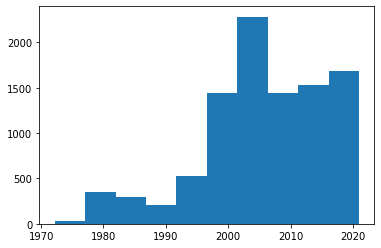

In [ ]:
plt.hist(all_matches['Date'])

Venue

In [ ]:
all_matches['Venue'].value_counts()

Korakuen Hall, Tokyo, Tokyo                           1243
New Sumo Hall - Ryogoku Kokugikan, Tokyo, Tokyo        729
Tokyo Dome, Tokyo, Tokyo                               330
Osaka Prefectural Gymnasium, Osaka, Osaka              322
Aichi Prefectural Gymnasium, Nagoya, Aichi             269
                                                      ... 
Tainai City General Gymnasium, Tainai, Niigata           1
Tomakomai City Gymnasium, Tomakomai, Hokkaido            1
Choshi City Gymnasium, Choshi, Chiba                     1
Ise Sun Arena Sub Arena, Mie, Oita                       1
Miyako Fish & Vegetables Market II, Miyako, Honshu       1
Name: Venue, Length: 687, dtype: int64

# Machine Learning

## Adding past information

Start by doubling up each match. Each match will exist twice in the dataset, once from the perspective of each wrestler.

In [ ]:
def double_up_df(df):
  df_copy = df.copy()
  df_reversed = df.copy()
  df_reversed.columns = [ 'Date', 'Event', 'Venue', 'Attendance', 'Card Ranking', 'Match Time', 'Person 2 Champion', 'Person 2 ID',
       'Person 2 Name', 'Person 1 Champion', 'Person 1 ID', 'Person 1 Name',
       'Result Descriptor', 'Stipulation', 'Title', 'WON Rating', 'Result']
  df_copy['Result'] = df_copy['Result'].transform(lambda x: 'win' if x == 'def' else x)
  df_reversed['Result'] = df_reversed['Result'].transform(lambda x: 'loss' if x == 'def' else x)
  return pd.concat([df_copy, df_reversed])

In [ ]:
all_matches_processed = double_up_df(all_matches)

Process dates as the number of days since Jan 1st 1970

In [ ]:
all_matches_processed['Date'] = (all_matches_processed['Date'] - np.datetime64('1970-01-01'))
all_matches_processed['Date'] = [timedelta.days for timedelta in all_matches_processed['Date']]

In [ ]:
all_matches_processed = all_matches_processed.sort_values('Date')

The result of a match is often influenced by the results of the matches that have come before, and how long ago those matches were. My aim here is to make the previous three match results for a wrestler, as well as the time since these matches, features in the prediction.
I will also make the previous three match results for a particular matchup of two wrestlers (and the time since these matches) features in the prediction.

Make a list of every wrestler ID and every combination of wrestlers who have wrestled each other.

In [ ]:
all_ids = all_matches_processed['Person 1 ID'].drop_duplicates()

In [ ]:
all_combos = (all_matches_processed['Person 1 ID'] + ' vs. ' + all_matches_processed['Person 2 ID']).drop_duplicates()

Generate dictionaries to record match results.

In [ ]:
match_3_result = []
match_2_result = []
match_1_result = []
match_3_date = []
match_2_date = []
match_1_date = []

In [ ]:
match_3_betwixt_result = []
match_2_betwixt_result = []
match_1_betwixt_result = []
match_3_betwixt_date = []
match_2_betwixt_date = []
match_1_betwixt_date = []

In [ ]:
id_dict = {}
for id in all_ids.values:
  id_dict[id] = [None, None, None, None, None, None]

In [ ]:
combo_dict = {}
for combo in all_combos:
  combo_dict[combo] = [None, None, None, None, None, None]

For each match:

- figure out if this person has a had a match before. If so, update the array in the dict with details of this match, and add to the lists. If not, add the details of this match to the array.
- figure out if these two people have had a match before. Same as above.

In [ ]:
for date, person_1, person_2, result in zip(all_matches_processed['Date'],all_matches_processed['Person 1 ID'],all_matches_processed['Person 2 ID'],all_matches_processed['Result']):
  # matches for person_1 only
  previous_match_results = id_dict[person_1][:3]
  previous_match_dates = id_dict[person_1][3:]
  match_3_result.append(previous_match_results[0])
  match_2_result.append(previous_match_results[1])
  match_1_result.append(previous_match_results[2])
  if previous_match_results[0] == None:
    match_3_date.append(None)
  else:
    match_3_date.append(date - previous_match_dates[0])
  if previous_match_results[1] == None:
    match_2_date.append(None)
  else:
    match_2_date.append(date - previous_match_dates[1])
  if previous_match_results[2] == None:
    match_1_date.append(None)
  else:
    match_1_date.append(date - previous_match_dates[2])
  current_match_results = (previous_match_results + [result])[1:]
  current_match_dates = (previous_match_dates + [date])[1:]
  id_dict[person_1] = current_match_results + current_match_dates

  # betwixt matches
  match_name = person_1 + ' vs. ' + person_2
  previous_match_results = combo_dict[match_name][:3]
  previous_match_dates = combo_dict[match_name][3:]
  match_3_betwixt_result.append(previous_match_results[0])
  match_2_betwixt_result.append(previous_match_results[1])
  match_1_betwixt_result.append(previous_match_results[2])
  if previous_match_results[0] == None:
    match_3_betwixt_date.append(None)
  else:
    match_3_betwixt_date.append(date - previous_match_dates[0])
  if previous_match_results[1] == None:
    match_2_betwixt_date.append(None)
  else:
    match_2_betwixt_date.append(date - previous_match_dates[1])
  if previous_match_results[2] == None:
    match_1_betwixt_date.append(None)
  else:
    match_1_betwixt_date.append(date - previous_match_dates[2])
  current_match_results = (previous_match_results + [result])[1:]
  current_match_dates = (previous_match_dates + [date])[1:]
  combo_dict[match_name] = current_match_results + current_match_dates

In [ ]:
all_matches_processed['Match 3 Result'] = match_3_result
all_matches_processed['Match 2 Result'] = match_2_result
all_matches_processed['Match 1 Result'] = match_1_result
all_matches_processed['Match 3 Days Since'] = match_3_date
all_matches_processed['Match 2 Days Since'] = match_2_date
all_matches_processed['Match 1 Days Since'] = match_1_date
all_matches_processed['Match 3 Betwixt Result'] = match_3_betwixt_result
all_matches_processed['Match 2 Betwixt Result'] = match_2_betwixt_result
all_matches_processed['Match 1 Betwixt Result'] = match_1_betwixt_result
all_matches_processed['Match 3 Betwixt Days Since'] = match_3_betwixt_date
all_matches_processed['Match 2 Betwixt Days Since'] = match_2_betwixt_date
all_matches_processed['Match 1 Betwixt Days Since'] = match_1_betwixt_date

## Splitting Test and Train

In this instance, I will use matches from 2012 - 2018 as the training set, 2019 matches as a validation set, and 2020 matches as a test set.

In [ ]:
df_train_and_val = all_matches_processed[all_matches_processed['Date'] < 18262]
df_train = df_train_and_val[df_train_and_val['Date'] < 17897].copy()
df_val = df_train_and_val[df_train_and_val['Date'] >= 17897].copy()
df_test = all_matches_processed[all_matches_processed['Date'] >= 18262].copy()

## Preprocessing Proper

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

2012 Jan 1st is the start date for the training set.



In [ ]:
df_train = df_train[df_train['Date'] > 15340]

In [ ]:
y_train = df_train['Result']

In [ ]:
y_val = df_val['Result']

Classifying event type - I will class all events into the following categories: G1 Specials, G1 Climax shows, Best of Super Juniors, 'Road to' shows, Super J-Cup shows, Wrestle Kingdom, Dominion, New Japan Cup, mid-level shows, Lion's Break, and other.

In [ ]:
def classify_event_type(event_name):
  if 'g1 special' in event_name.lower():
    return 'G1 Special'
  if 'g1 climax' in event_name.lower() and 'day' in event_name.lower():
    return 'G1'
  if 'best' in event_name.lower() and 'super' in event_name.lower():
    return 'BoSJ'
  if 'road' in event_name.lower():
    return 'Road To'
  if 'j-cup' in event_name.lower():
    return 'J-Cup'
  if 'wrestle kingdom' in event_name.lower() or 'wrestlekingdom' in event_name.lower():
    return 'Wrestle Kingdom'
  if 'dominion' in event_name.lower():
    return 'Dominion'
  if 'new japan cup' in event_name.lower():
    return 'NJ Cup'
  if 'dontaku' in event_name.lower() or 'king of pro wrestling' in event_name.lower() or 'king of pro-wrestling' in event_name.lower() or 'power struggle' in event_name.lower() or 'beginning' in event_name.lower() or 'anniversary' in event_name.lower() or 'invasion' in event_name.lower() or 'destruction' in event_name.lower() or 'fighting spirit' in event_name.lower() or 'sakura' in event_name.lower() or 'hinokuni' in event_name.lower() or 'evolved' in event_name.lower():
    return 'Mid-level Event'
  if 'break' in event_name.lower():
    return 'Lion\'s Break'
  return 'Other'

In [ ]:
df_train['Event Type'] = [classify_event_type(event) for event in df_train['Event']]

In [ ]:
df_val['Event Type'] = [classify_event_type(event) for event in df_val['Event']]

Transform all attributes into numeric form.

In [ ]:
class MakeNumericTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y = None):
    return self
  
  def transform(self, X, y = None):
    
    X_numeric = []
    for column in X:
      X_column_numeric = []
      for value in X[column]:
        if pd.isna(value):
          X_column_numeric.append(0)
        elif value == None:
          X_column_numeric.append(0)
        elif value == 'draw':
          X_column_numeric.append(0)
        elif value == 'loss':
          X_column_numeric.append(-1)
        elif value == 'win':
          X_column_numeric.append(1)
        else:
          X_column_numeric.append(value)
      X_numeric.append(X_column_numeric)
    return np.transpose(np.asarray(X_numeric))

In [ ]:
num_attribs = ['Card Ranking','Match 3 Result','Match 2 Result', 'Match 1 Result',
       'Match 3 Days Since', 'Match 2 Days Since', 'Match 1 Days Since',
       'Match 3 Betwixt Result', 'Match 2 Betwixt Result',
       'Match 1 Betwixt Result', 'Match 3 Betwixt Days Since',
       'Match 2 Betwixt Days Since', 'Match 1 Betwixt Days Since','Date','Person 1 Champion',
       'Person 2 Champion']

In [ ]:
cat_attribs = ['Event Type','Venue','Person 1 ID','Person 2 ID','Title']

In [ ]:
num_pipeline = Pipeline([
                         ('make_numeric',MakeNumericTransformer()),
                         ('std_scaler',StandardScaler())
])

full_pipeline = ColumnTransformer([
                                   ('num',num_pipeline,num_attribs),
                                   ('cat',OneHotEncoder(handle_unknown='ignore'),cat_attribs)
])

In [ ]:
X_train_prepared = full_pipeline.fit_transform(df_train)

In [ ]:
X_val_prepared = full_pipeline.transform(df_val)

## XGBoost

I will train the data on XGBoost, using the validation set for early stopping.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [ ]:
xgb = XGBClassifier()

In [ ]:
y_train_prepared = np.asarray([{'loss':0, 'draw':0, 'win':1}[result] for result in y_train])

In [ ]:
y_val_prepared = np.asarray([{'loss':0, 'draw':0, 'win':1}[result] for result in y_val])

In [ ]:
eval_set = [(X_val_prepared.toarray(), y_val_prepared)]

In [ ]:
xgb.fit(X_train_prepared, y_train_prepared, eval_metric="error", eval_set=eval_set, verbose=True, early_stopping_rounds=1000)

[0]	validation_0-error:0.481203
Will train until validation_0-error hasn't improved in 1000 rounds.
[1]	validation_0-error:0.464912
[2]	validation_0-error:0.472431
[3]	validation_0-error:0.474937
[4]	validation_0-error:0.478697
[5]	validation_0-error:0.486216
[6]	validation_0-error:0.484962
[7]	validation_0-error:0.489975
[8]	validation_0-error:0.47995
[9]	validation_0-error:0.464912
[10]	validation_0-error:0.454887
[11]	validation_0-error:0.454887
[12]	validation_0-error:0.458647
[13]	validation_0-error:0.462406
[14]	validation_0-error:0.468672
[15]	validation_0-error:0.43609
[16]	validation_0-error:0.434837
[17]	validation_0-error:0.466165
[18]	validation_0-error:0.467419
[19]	validation_0-error:0.444862
[20]	validation_0-error:0.45614
[21]	validation_0-error:0.462406
[22]	validation_0-error:0.449875
[23]	validation_0-error:0.463659
[24]	validation_0-error:0.47995
[25]	validation_0-error:0.47995
[26]	validation_0-error:0.488722
[27]	validation_0-error:0.483709
[28]	validation_0-error

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
accuracy_score(y_val_prepared, xgb.predict(X_val_prepared))

0.5776942355889725

## Testing

In [ ]:
y_test = df_test['Result']

In [ ]:
df_test['Event Type'] = [classify_event_type(event) for event in df_test['Event']]

In [ ]:
X_test_prepared = full_pipeline.transform(df_test)

In [ ]:
y_test_prepared = np.asarray([{'loss':0, 'draw':0, 'win':1}[result] for result in y_test])

In [ ]:
accuracy_score(y_test_prepared, xgb.predict(X_test_prepared))

0.5415430267062314

Clearly this method has not worked particularly well.

# Creating prediction engine and testing on Wrestle Kingdom 15

Just for fun, I'm creating a prediction engine based on all the data.

In [ ]:
all_matches_post_2012 = all_matches_processed[all_matches_processed['Date'] > 15340].copy()
y_all = all_matches_post_2012['Result']
y_all_prepared = np.asarray([{'loss':0, 'draw':0, 'win':1}[result] for result in y_all])
all_matches_post_2012['Event Type'] = [classify_event_type(event) for event in all_matches_post_2012['Event']]
X_all_prepared = full_pipeline.transform(all_matches_post_2012)

Intentionally overfitting - when using too few estimators the engine doesn't commit to a choice.

In [ ]:
xgb = XGBClassifier(n_estimators = 1000)
xgb.fit(X_all_prepared, y_all_prepared, eval_metric="error", verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Create a dict to change names into IDs

In [ ]:
name_to_id_dict = {name:id for name, id in zip(all_matches_processed['Person 1 Name'],all_matches_processed['Person 1 ID'])}
for name, id in zip(all_matches_processed['Person 2 Name'],all_matches_processed['Person 2 ID']):
  if not name in name_to_id_dict.keys():
    name_to_id_dict[name] = id

Creating predictions for future matches: this is where you can enter details

In [ ]:
def predict_winner(datetext, card_ranking, person_1_champion, person_2_champion, event_type, venue, person_1_name, person_2_name, title):
  match = {}
  date = (np.datetime64(datetext) - np.datetime64('1970-01-01')) / np.timedelta64(1, 'D') # enter date here
  match['Date'] = date
  match['Card Ranking'] = card_ranking
  match['Person 1 Champion'] = person_1_champion
  match['Person 2 Champion'] = person_2_champion
  match['Event Type'] = event_type
  match['Venue'] = venue
  match['Person 1 ID'] = name_to_id_dict[person_1_name]
  match['Person 2 ID'] = name_to_id_dict[person_2_name]
  match['Title'] = title

  match_reversed = {}
  match_reversed['Date'] = match['Date']
  match_reversed['Card Ranking'] = match['Card Ranking']
  match_reversed['Person 1 Champion'] = match['Person 2 Champion']
  match_reversed['Person 2 Champion'] = match['Person 1 Champion']
  match_reversed['Event Type'] = match['Event Type']
  match_reversed['Venue'] = match['Venue']
  match_reversed['Person 1 ID'] = match['Person 2 ID']
  match_reversed['Person 2 ID'] = match['Person 1 ID']
  match_reversed['Title'] = match['Title']

  match['Match 3 Result'] = id_dict[match['Person 1 ID']][0]
  match['Match 2 Result'] = id_dict[match['Person 1 ID']][1]
  match['Match 1 Result'] = id_dict[match['Person 1 ID']][2]
  match['Match 3 Days Since'] = match['Date'] - id_dict[match['Person 1 ID']][3]
  match['Match 2 Days Since'] = match['Date'] - id_dict[match['Person 1 ID']][4] 
  match['Match 1 Days Since'] = match['Date'] - id_dict[match['Person 1 ID']][5]

  try:
    match['Match 3 Betwixt Result'] = combo_dict[match['Person 1 ID'] + ' vs. ' + match['Person 2 ID']][0]
  except:
    match['Match 3 Betwixt Result'] = 0
  try:
    match['Match 2 Betwixt Result'] = combo_dict[match['Person 1 ID'] + ' vs. ' + match['Person 2 ID']][1]
  except:
    match['Match 2 Betwixt Result'] = 0
  try:
    match['Match 1 Betwixt Result'] = combo_dict[match['Person 1 ID'] + ' vs. ' + match['Person 2 ID']][2]
  except:
    match['Match 1 Betwixt Result'] = 0
  try:
    match['Match 3 Betwixt Days Since'] = match['Date'] - combo_dict[match['Person 1 ID'] + ' vs. ' + match['Person 2 ID']][3]
  except:
    match['Match 3 Betwixt Days Since'] = 0
  try:
    match['Match 2 Betwixt Days Since'] = match['Date'] - combo_dict[match['Person 1 ID'] + ' vs. ' + match['Person 2 ID']][4]
  except:
    match['Match 2 Betwixt Days Since'] = 0
  try:
    match['Match 1 Betwixt Days Since'] = match['Date'] - combo_dict[match['Person 1 ID'] + ' vs. ' + match['Person 2 ID']][5]
  except:
    match['Match 1 Betwixt Days Since'] = 0

  match_reversed['Match 3 Result'] = id_dict[match_reversed['Person 1 ID']][0]
  match_reversed['Match 2 Result'] = id_dict[match_reversed['Person 1 ID']][1]
  match_reversed['Match 1 Result'] = id_dict[match_reversed['Person 1 ID']][2]
  match_reversed['Match 3 Days Since'] = match_reversed['Date'] - id_dict[match_reversed['Person 1 ID']][3]
  match_reversed['Match 2 Days Since'] = match_reversed['Date'] - id_dict[match_reversed['Person 1 ID']][4] 
  match_reversed['Match 1 Days Since'] = match_reversed['Date'] - id_dict[match_reversed['Person 1 ID']][5]

  try:
    match_reversed['Match 3 Betwixt Result'] = combo_dict[match_reversed['Person 1 ID'] + ' vs. ' + match_reversed['Person 2 ID']][0]
  except:
    match_reversed['Match 3 Betwixt Result'] = None
  try:
    match_reversed['Match 2 Betwixt Result'] = combo_dict[match_reversed['Person 1 ID'] + ' vs. ' + match_reversed['Person 2 ID']][1]
  except:
    match_reversed['Match 2 Betwixt Result'] = None
  try:
    match_reversed['Match 1 Betwixt Result'] = combo_dict[match_reversed['Person 1 ID'] + ' vs. ' + match_reversed['Person 2 ID']][2]
  except:
    match_reversed['Match 1 Betwixt Result'] = None
  try:
    match_reversed['Match 3 Betwixt Days Since'] = match_reversed['Date'] - combo_dict[match_reversed['Person 1 ID'] + ' vs. ' + match_reversed['Person 2 ID']][3]
  except:
    match_reversed['Match 3 Betwixt Days Since'] = 0
  try:
    match_reversed['Match 2 Betwixt Days Since'] = match_reversed['Date'] - combo_dict[match_reversed['Person 1 ID'] + ' vs. ' + match_reversed['Person 2 ID']][4]
  except:
    match_reversed['Match 2 Betwixt Days Since'] = 0
  try:
    match_reversed['Match 1 Betwixt Days Since'] = match_reversed['Date'] - combo_dict[match_reversed['Person 1 ID'] + ' vs. ' + match_reversed['Person 2 ID']][5]
  except:
    match_reversed['Match 1 Betwixt Days Since'] = 0
  
  df_match = pd.DataFrame()
  df_match = df_match.append(match, ignore_index=True)
  df_match = df_match.append(match_reversed, ignore_index=True)

  df_match['Attendance'] = ''
  df_match['Match Time'] = ''
  df_match['Result Descriptor'] = ''
  df_match['Stipulation'] = ''
  df_match['WON Rating'] = ''
  df_match['Event'] = ''
  df_match['Result'] = ''
  df_match['Person 1 Name'] = ''
  df_match['Person 2 Name'] = ''

  df_match = df_match[df_train.columns]
  X_match_processed = full_pipeline.transform(df_match)
  prediction_matrix = xgb.predict_proba(X_match_processed)
  prob_1_wins = prediction_matrix[0][1]
  prob_2_wins = prediction_matrix[1][1]
  prob_draw = 1 - prob_1_wins - prob_2_wins
  if prob_draw < 0:
    new_prob_1_wins = prob_1_wins / (prob_1_wins + prob_2_wins)
    new_prob_2_wins = prob_2_wins / (prob_1_wins + prob_2_wins)
    prob_1_wins = new_prob_1_wins
    prob_2_wins = new_prob_2_wins
    prob_draw = 0
  
  print(person_1_name+' wins with probability '+'{:.2%}'.format(prob_1_wins))
  print(person_2_name+' wins with probability '+'{:.2%}'.format(prob_2_wins))
  print('Draw with probability '+'{:.2%}'.format(prob_draw))

Predicting the Wrestle Kingdom 15 results...

In [ ]:
predict_winner('2021-01-04',1,1,0,'Wrestle Kingdom','Tokyo Dome, Tokyo, Tokyo','Tetsuya Naito','Kota Ibushi','IWGP Intercontinental ChampionshipIWGP World Heavyweight Championship')

Tetsuya Naito wins with probability 36.40%
Kota Ibushi wins with probability 46.70%
Draw with probability 16.90%


In [ ]:
predict_winner('2021-01-04',2,0,0,'Wrestle Kingdom','Tokyo Dome, Tokyo, Tokyo','Kazuchika Okada','Will Ospreay','')

Kazuchika Okada wins with probability 63.17%
Will Ospreay wins with probability 18.59%
Draw with probability 18.24%


In [ ]:
predict_winner('2021-01-04',3,0,0,'Wrestle Kingdom','Tokyo Dome, Tokyo, Tokyo','Hiroshi Tanahashi','Great O-Khan','')

Hiroshi Tanahashi wins with probability 61.94%
Great O-Khan wins with probability 38.06%
Draw with probability 0.00%


In [ ]:
predict_winner('2021-01-04',4,0,0,'Wrestle Kingdom','Tokyo Dome, Tokyo, Tokyo','KENTA','Satoshi Kojima','')

KENTA wins with probability 50.49%
Satoshi Kojima wins with probability 49.51%
Draw with probability 0.00%


In [ ]:
predict_winner('2021-01-04',6,0,0,'Wrestle Kingdom','Tokyo Dome, Tokyo, Tokyo','Hiromu Takahashi','El Phantasmo','')

Hiromu Takahashi wins with probability 54.24%
El Phantasmo wins with probability 45.76%
Draw with probability 0.00%


And then Night 2...



In [ ]:
predict_winner('2021-01-05',1,1,0,'Wrestle Kingdom','Tokyo Dome, Tokyo, Tokyo','Kota Ibushi','Jay White','IWGP Intercontinental ChampionshipIWGP World Heavyweight Championship')

Kota Ibushi wins with probability 40.81%
Jay White wins with probability 45.77%
Draw with probability 13.43%


In [ ]:
predict_winner('2021-01-05',1,1,0,'Wrestle Kingdom','Tokyo Dome, Tokyo, Tokyo','Tetsuya Naito','Jay White','IWGP Intercontinental ChampionshipIWGP World Heavyweight Championship')

Tetsuya Naito wins with probability 34.44%
Jay White wins with probability 43.30%
Draw with probability 22.26%


In [ ]:
predict_winner('2021-01-05',2,1,0,'Wrestle Kingdom','Tokyo Dome, Tokyo, Tokyo','Taiji Ishimori','Hiromu Takahashi','IWGP Junior Heavyweight Title')

Taiji Ishimori wins with probability 54.40%
Hiromu Takahashi wins with probability 45.60%
Draw with probability 0.00%


In [ ]:
predict_winner('2021-01-05',2,1,0,'Wrestle Kingdom','Tokyo Dome, Tokyo, Tokyo','Taiji Ishimori','El Phantasmo','IWGP Junior Heavyweight Title')

Taiji Ishimori wins with probability 69.45%
El Phantasmo wins with probability 30.55%
Draw with probability 0.00%


In [ ]:
predict_winner('2021-01-05',3,0,0,'Wrestle Kingdom','Tokyo Dome, Tokyo, Tokyo','SANADA','EVIL','')

SANADA wins with probability 48.22%
EVIL wins with probability 45.46%
Draw with probability 6.32%


In [ ]:
predict_winner('2021-01-05',4,1,0,'Wrestle Kingdom','Tokyo Dome, Tokyo, Tokyo','Shingo Takagi','Jeff Cobb','NEVER Openweight Championship')

Shingo Takagi wins with probability 50.88%
Jeff Cobb wins with probability 43.33%
Draw with probability 5.79%


Final predicted results:

Night 1:
- Kota Ibushi def. Tetsuya Naito (c)
- Kazuchika Okada def. Will Ospreay
- Hiroshi Tanahashi def. Great O'Khan
- KENTA def. Satoshi Kojima
- Hiromu Takahashi def. El Phantasmo

Night 2:
- Jay White def. Kota Ibushi (c)
- Taiji Ishimori (c) def. Hiromu Takahashi
- SANADA def. EVIL
- Shingo Takagi (c) def. Jeff Cobb